In [17]:
using PyPlot

using Distributed
# addprocs();

@everywhere using Revise

In [18]:
@everywhere using RealNeuralNetworks.Neurons
@everywhere using RealNeuralNetworks.Neurons.Segments 
@everywhere using RealNeuralNetworks.NeuralNets

# using JLD2
using HDF5
# using PyPlot
using MultivariateStats
using ProgressMeter
using LightGraphs, MetaGraphs 
using StatsBase
using SparseArrays
using JSON

@everywhere const DATASET_DIR = expanduser("../01_data")

# Create connectivity matrix

In [19]:
# using JuliaDB

# db = JuliaDB.loadtable("../01_data/$DATASET_DATE/features.csv")

using HDF5

neuronIdList = h5read("$(DATASET_DIR)/data.h5", "neuronIdList")

# using JSON
# neuron_ids = JSON.parsefile("$(DATASET_DIR)/neuron_ids.json")
# neuronIdList2 = JSON.parsefile("$(DATASET_DIR)/neuron_ids.json")["analysis"]
# @assert all(neuronIdList .== neuronIdList2)

2563-element Vector{Int64}:
 82140
 82142
 82143
 82145
 82146
 82160
 82161
 82164
 82169
 82170
 82173
 82175
 82176
     ⋮
 81827
 81835
 81839
 81844
 81849
 81851
 81855
 81858
 81868
 81869
 81870
 81874

In [20]:
neuronList = pmap(x->Neurons.load("$(DATASET_DIR)/bin/$(x).bin"), neuronIdList);

In [21]:
net = NeuralNets.NeuralNet(neuronList, neuronIdList)
MetaGraphs.weightfield!(net, :num_synapses)

println("number of nodes: ", LightGraphs.nv(net))

number of nodes: 2563


┌ Warning: skipped self connection edges from 0 neurons.
└ @ RealNeuralNetworks.NeuralNets /Users/jwu/.julia/dev/RealNeuralNetworks/src/NeuralNets.jl:69


In [22]:
# h5open("$(DATASET_DIR)/conn.h5", "r+") do f
#     o_delete(f, "synNumConnMatrix")
#     o_delete(f, "psdSizeConnMatrix")
# end

synNumConnMatrix = NeuralNets.get_synapse_number_connectivity_matrix(net)
psdSizeConnMatrix = NeuralNets.get_psd_size_connectivity_matrix(net)

using SparseArrays
I1,J1,V1 = findnz(synNumConnMatrix)
I2,J2,V2 = findnz(psdSizeConnMatrix)
@assert all(I1.==I2)
@assert all(J1.==J2)
# connMatrix = zeros(Int, (length(I1), 4))
# the columns: neuron1, neuron2, synapse number, PSD size
connMatrix = hcat(I1,J1,V1,V2)


# h5open("$(DATASET_DIR)/data.h5", "r+") do f
#     f["connMatrix"] = connMatrix
# end

# LightGraphs.savegraph("net.gt", net)
# LightGraphs.savegraph("net.lgz", net)

using GraphIO
open("$(DATASET_DIR)/net.graphml", "w") do f 
    GraphIO.GraphML.savegraphml(f, net, "neuralnet")
end

@assert any(synNumConnMatrix .> 0)
@assert any(psdSizeConnMatrix .> 0) 

In [35]:
# h5open("$(DATASET_DIR)/data.h5", "r+") do f
#     f["connMatrix"] = connMatrix
# end

42452×4 Matrix{Int64}:
  175     1  2  1809
  192     1  2  3995
  201     1  1  2117
  225     1  1  1364
  427     1  1  1087
  436     1  1  1997
  455     1  1  1179
  477     1  1  2571
  501     1  2  4926
  502     1  1  2258
  516     1  1  2466
  653     1  1  2700
  667     1  1   202
    ⋮           
 2014  2562  1   942
 2017  2562  4  8325
 2021  2562  1  2328
 2024  2562  3  4039
 2042  2562  1   551
 2045  2562  1  3180
 2135  2562  1   992
 2191  2562  1  2166
 2419  2562  1   475
 2425  2562  1  2857
 2441  2562  1  2817
 2446  2562  1  2208

# Reorder connectivity matrix based on morphological clustering

In [23]:
using SparseArrays
I = connMatrix[:,1]
J = connMatrix[:,2]
synNumList= connMatrix[:,3]
psdSizeList = connMatrix[:,4]

neuronNum = maximum(I)

synNumConnMatrix = sparse(I,J,synNumList, neuronNum, neuronNum)
psdSizeConnMatrix = sparse(I,J,psdSizeList, neuronNum, neuronNum)

println("number of synapses: ", length(synNumList))
println("size of connectivity matrix: ", size(psdSizeConnMatrix))

number of synapses: 42452
size of connectivity matrix: (2563, 2563)


In [24]:
orders = h5read("$(DATASET_DIR)/data.h5", "/nblast/zfishTable/orders")
# orderedClusters = h5read("$(DATASET_DIR)/data.h5", "/nblast/zfishTable/orderedClusters")
orderedNeuronIdList = h5read("$(DATASET_DIR)/data.h5", "/nblast/zfishTable/orderedNeuronIdList")
@show length(orders)
# @show length(orderedClusters)
@show length(orderedNeuronIdList)

orderedSynNumConnMatrix = NeuralNets.reorder_matrix(synNumConnMatrix, orders)
orderedPsdSizeConnMatrix = NeuralNets.reorder_matrix(psdSizeConnMatrix, orders);


length(orders) = 2563
length(orderedNeuronIdList) = 2563


In [33]:
using PlotlyJS
# using SparseArrays


import Pkg
include(joinpath(Pkg.devdir(), "RealNeuralNetworks/src/Utils/PlotRecipes.jl"))
using .PlotRecipes

syn_num_plot = PlotRecipes.plot_connectivity_matrix(orderedSynNumConnMatrix; 
    title = "synapse number connectivity_matrix");

using ORCA
# PlotlyJS.savefig(syn_num_plot, 
#    "$(DATASET_DIR)/figs/connectivity/syn_num_connectivity_matrix_ordered_by_nblast_clustering.svg")
PlotlyJS.savefig(syn_num_plot, 
   "$(DATASET_DIR)/figs/connectivity/syn_num_connectivity_matrix_ordered_by_nblast_clustering.png")

"../01_data/figs/connectivity/syn_num_connectivity_matrix_ordered_by_nblast_clustering.png"

In [30]:
psd_size_plot = PlotRecipes.plot_connectivity_matrix(orderedPsdSizeConnMatrix; 
    title = "psd size connectivity_matrix");

using ORCA
PlotlyJS.savefig(psd_size_plot, "$(DATASET_DIR)/figs/connectivity/psd_size_connectivity_matrix_ordered_by_nblast_clustering.svg")
PlotlyJS.savefig(psd_size_plot, "$(DATASET_DIR)/figs/connectivity/psd_size_connectivity_matrix_ordered_by_nblast_clustering.png")

"../01_data/figs/connectivity/psd_size_connectivity_matrix_ordered_by_nblast_clustering.png"

## Correlation coefficient of neuron connectivity patterns

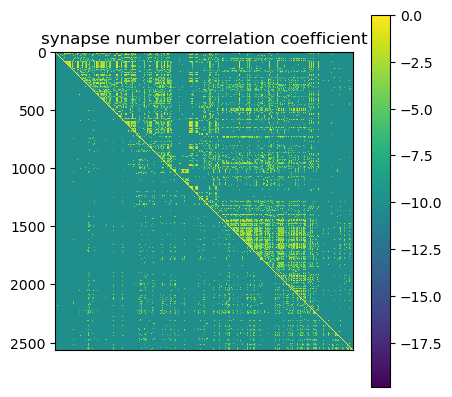

In [31]:
using Statistics
using SparseArrays

function conn_cor(orderedWeightMatrix::SparseMatrixCSC)
    orderedConnCorr = ones(Float64, size(orderedWeightMatrix))

    Threads.@threads for i = 1:size(orderedWeightMatrix,1)
        for j = i+1:size(orderedWeightMatrix, 2)
            orderedConnCorr[i,j] = cor(orderedWeightMatrix[i,:], orderedWeightMatrix[j,:])
        end
    end

    Threads.@threads for j=1:size(orderedWeightMatrix, 2)
        for i=j+1:size(orderedWeightMatrix, 1)
            orderedConnCorr[i,j] = cor(orderedWeightMatrix[:,i], orderedWeightMatrix[:,j])
        end
    end
    for i in 1:size(orderedConnCorr, 1)
        for j in 1:size(orderedConnCorr, 2)
            if isnan(orderedConnCorr[i,j]) || orderedConnCorr[i,j]<=0
                # make sure that there is no negative values
                orderedConnCorr[i,j] = 1e-3
            end
        end
    end
    orderedConnCorr
end

synNumCor = conn_cor(orderedSynNumConnMatrix)

PyPlot.matshow(log2.(synNumCor))
PyPlot.title("synapse number correlation coefficient")
PyPlot.colorbar()
PyPlot.xticks([])
PyPlot.savefig("$(DATASET_DIR)/figs/connectivity/syn_num_cor.svg")
PyPlot.savefig("$(DATASET_DIR)/figs/connectivity/syn_num_cor.png")

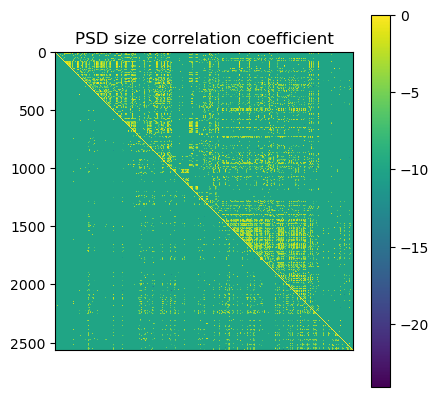

In [32]:
psdSizeCor = conn_cor(orderedPsdSizeConnMatrix)

PyPlot.matshow(log2.(psdSizeCor))
PyPlot.colorbar()
PyPlot.title("PSD size correlation coefficient")
PyPlot.xticks([])
PyPlot.savefig("$(DATASET_DIR)/figs/connectivity/psd_size_cor.svg")
PyPlot.savefig("$(DATASET_DIR)/figs/connectivity/psd_size_cor.png")

# Community Detection

In [54]:
using LightGraphs

weightfield!(net, :num_synapses)

label, _ = LightGraphs.label_propagation(net)
println("classified as ", maximum(label), " communities")

classified as 360 communities


In [ ]:
# visualization


# Connectivity of neuron groups
We have classified neurons to 35 groups by hierarchical NBLAST clustering and manual splitting. We can take each group as a node and build a new graph

## Compare with manual classification 
Ashwin manually classified about 300 neurons. We would like to see whether there is consistency between these two classification